In [2]:
#standard libraries

import pandas as pd
import numpy as np

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#modelling
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

#error metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, PredictionErrorDisplay

#others
import math

#hide warnigns
import warnings

Use case: We have been provided with data from a single fisherman containing information about his recent catches from fishing activities. The fisherman, Mikkel, spends a lot of time recording all the measurements when he is actually only interested in the weight for selling the product. Mikkel has hired us to determine if, with the available data, we can optimize the process, as sometimes he does not have access to a scale.

Therefore, we prioritize interpretability over complexity. Let's begin.

# Exploratory Data Analysis


## Primary information

In [3]:
warnings.simplefilter(action='ignore', 
                      category=FutureWarning)

df = pd.read_csv("Fish.csv")
df.head()


,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


The dataset consits in 7 features and 159 observations. "Weight" is the target variable. All input  but Species are numerical variables

In [5]:
df.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,398.326415,26.247170,28.415723,31.227044,8.970994,4.417486
std,357.978317,9.996441,10.716328,11.610246,4.286208,1.685804
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,19.050000,21.000000,23.150000,5.944800,3.385650
50%,273.000000,25.200000,27.300000,29.400000,7.786000,4.248500
75%,650.000000,32.700000,35.500000,39.650000,12.365900,5.584500
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


It is seen that there is at least one observation with a weight equal to 0 - the data must be cleaned

## Target variable

The aim of this task is to be able to predict the weight. In order to achieve this, we need to first understand properly the weight distribution. Therefore, how does it look like?

<Axes: >

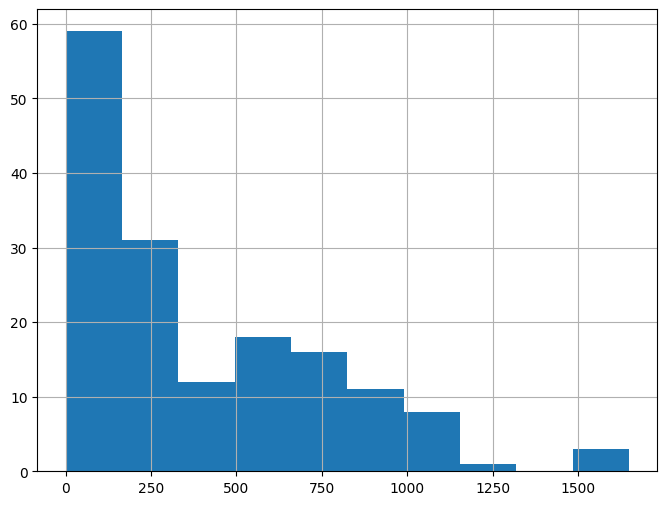

In [6]:
df.Weight.hist(figsize=(8,6))

It is observed that the histogram shows a non-parametric dataset, since it is not similar to any popular distribution. But, do species have anything to do on the weight distribution?

<Axes: xlabel='Species', ylabel='Weight'>

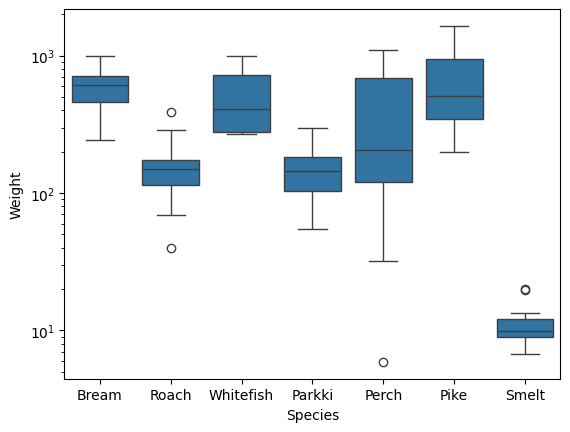

In [58]:
sns.boxplot(data=df, x="Species", y="Weight", log_scale=True)


This shows how the species affect the weight. There are a few outliers in Roach, however, this can be due to the little data we have, and thus, do not need to be dropped.

In the boxplot it is observed how different the variables are according to the spici. Whereas smelt fishes are short, small and light, bream are large, weighted and larges. Additionally, it is seen that there are a few outliers. However, there are some unconsistencies in the dataset since some values are wighted 0, and this cannot be possible. Therefore those values are removed.

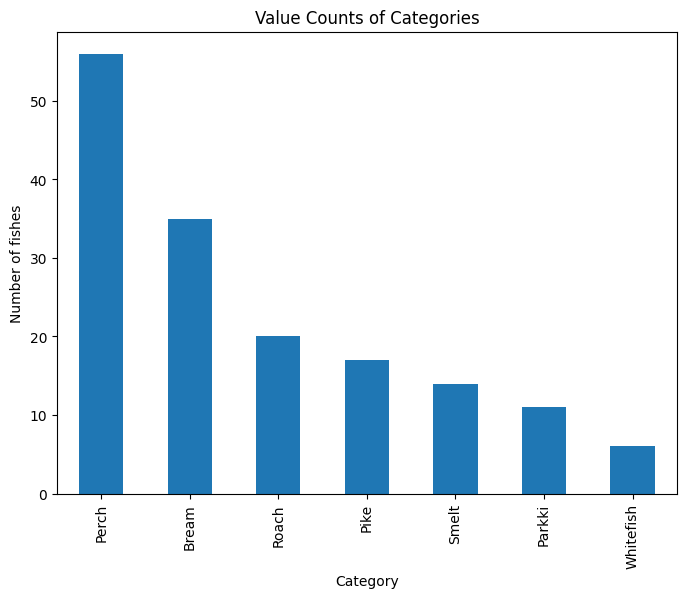

In [8]:
plt.figure(figsize=(8, 6))
df['Species'].value_counts().plot(kind='bar')
plt.title('Value Counts of Categories')
plt.xlabel('Category')
plt.ylabel('Number of fishes')
plt.show()

## Data correlations

From the graph, it can be observed that we have a small number of fish in each category. It is worth noting that the sample sizes are small, which could lead to unreliability. There is also some imbalance. If we work with categories, we should consider using resampling techniques.

<Axes: >

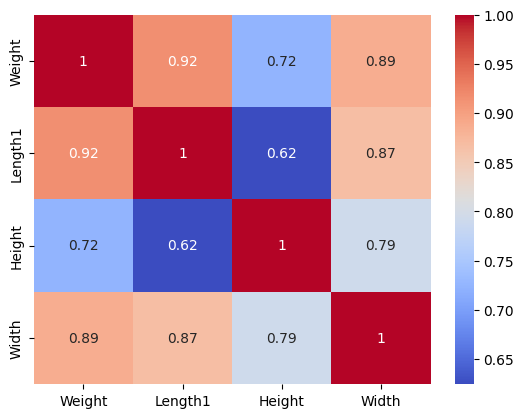

In [61]:
correlation_martrix = df.select_dtypes(include='float64').corr()
sns.heatmap(correlation_martrix, annot=True, cmap='coolwarm')

It is observed that there is a significant multicollinearity present in the dataset, especially on the length side. In other words, if one knows Length1, Length2, and Length3, they can also be known with high precision. In an ideal scenario, this can be mitigated by adding regularization techniques that emphasize the importance of features. However, for interpretability and due to their high value, they can be dropped later on.

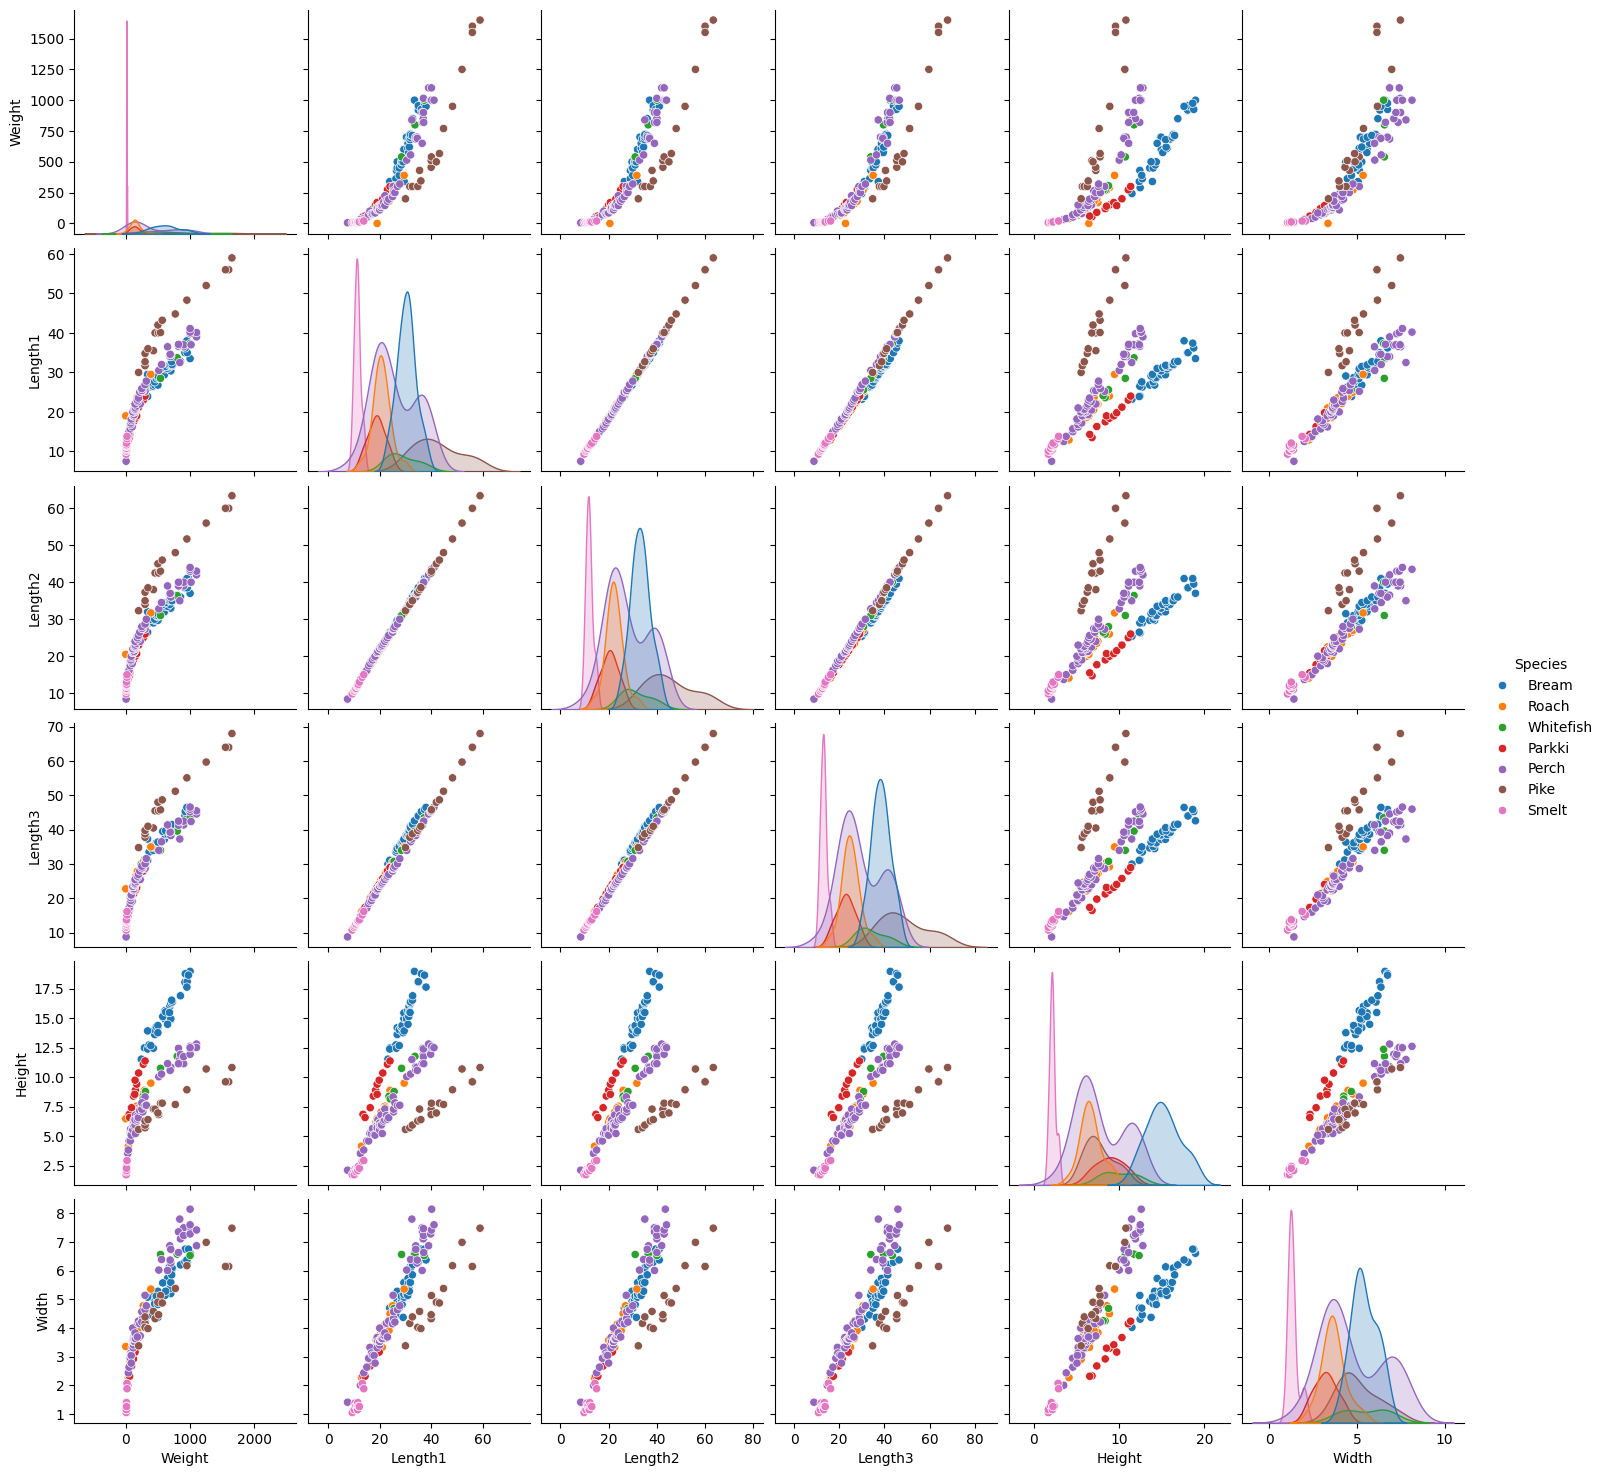

In [10]:
sns.pairplot(df, hue='Species')

In the pairplot it is observed the strong multicollinearity present among features as Lenth 1, 2 and 3, meaning that by knowing one length, one can know all the others, thus, these features are not adding information to the model and can be dropped.

Additionally, it is worth noticing that the species create clusters. This means that fishes among the same group usually have similar characteristics and behaviour.

Let's perform some cleaning:
1. Due to the strong multicollinearity present, Length2 and Length3 are dropped from the dataset
2. The obervations with weight equal to 0 are being dropped.

In [11]:
df = df.drop(columns=['Length2', 'Length3'])
df = df[df['Weight'] != 0]

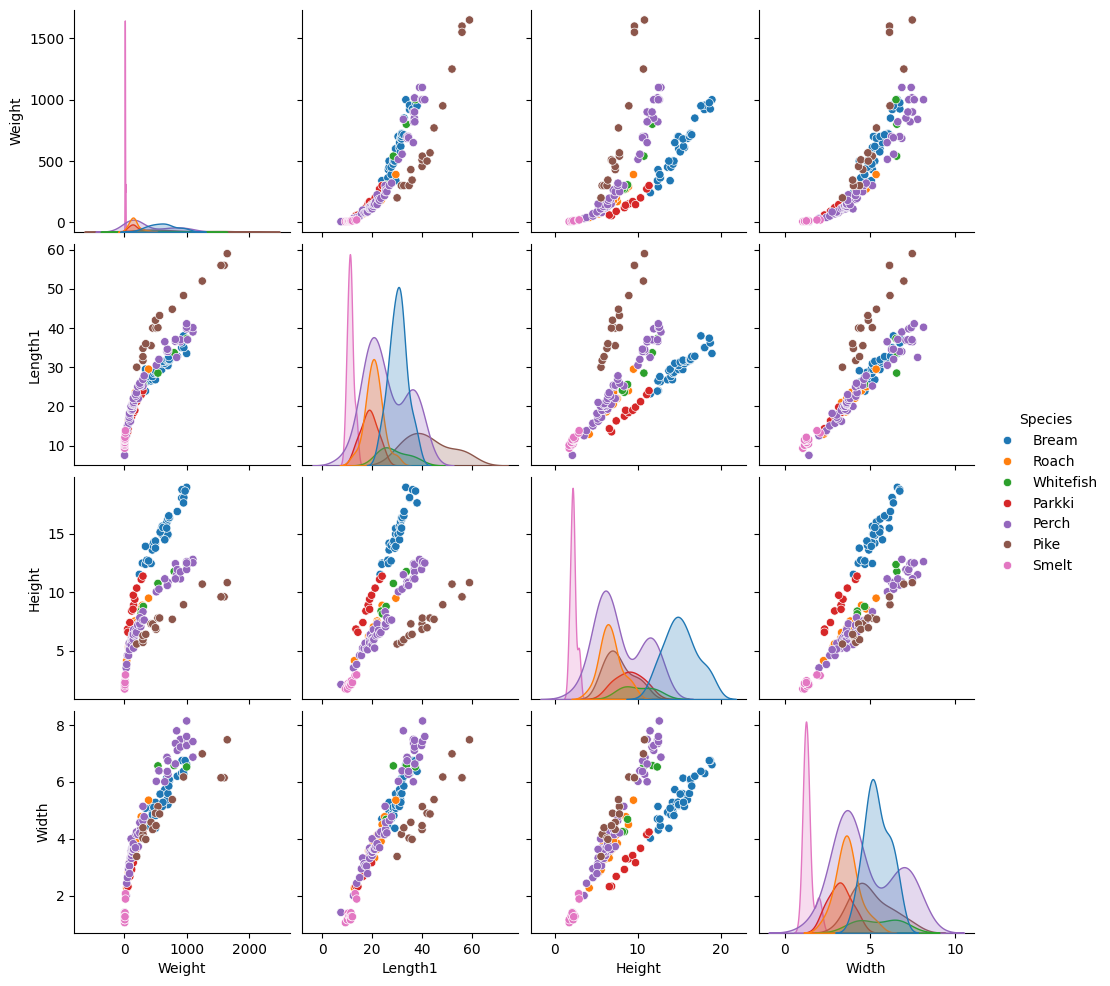

In [12]:
sns.pairplot(df, hue='Species')

The pairplot is very meaningful. It is possible to see the relationship between the features and the weight.

Some of the conclusions that can be extracted are as follows:

1. Weight appears to have a logarithmic correlation with the rest of the features.
2. A simple linear regression does not fit this data as it currently appears.
3. Different models are necessary, one for each 'line.' Perhaps a model per species will fit better; however, this might not be optimal since similarresults can be obtained with fewer models.

Making the target normally distributed will lead to better results. If our target is not normally distributed, it is possible to apply a transformation to it and then fit our regression to predict the transformed values.
Since the target is non-parametric, no transformation is need, since it is far from being normally distributed.

# Modelling

## Data Transformation

Since there is an exponential groeth, we are going to try to mitigate the ffect by logarithmic transfoming the variables

In [13]:
def log_transform(variable):
    return np.log10(variable)

In [14]:
ct = ColumnTransformer([
    ("numericals", 
     FunctionTransformer(log_transform), 
     df.select_dtypes(include=['float64']).columns)
])

transformed_data = pd.DataFrame(ct.fit_transform(df),
                                columns=df.select_dtypes(include=['float64']).columns)
                                
transformed_data = transformed_data.merge(df['Species'], 
                                          left_index=True, 
                                          right_index=True)

transformed_data.head()

,Weight,Length1,Height,Width,Species
0,2.383815,1.365488,1.061452,0.604226,Bream
1,2.462398,1.380211,1.096215,0.634034,Bream
2,2.531479,1.378398,1.092643,0.671737,Bream
3,2.559907,1.419956,1.104828,0.648896,Bream
4,2.633468,1.423246,1.094960,0.710456,Bream


Now all data has been logarithmic transformed. Let's see how the pariplot looks like now:

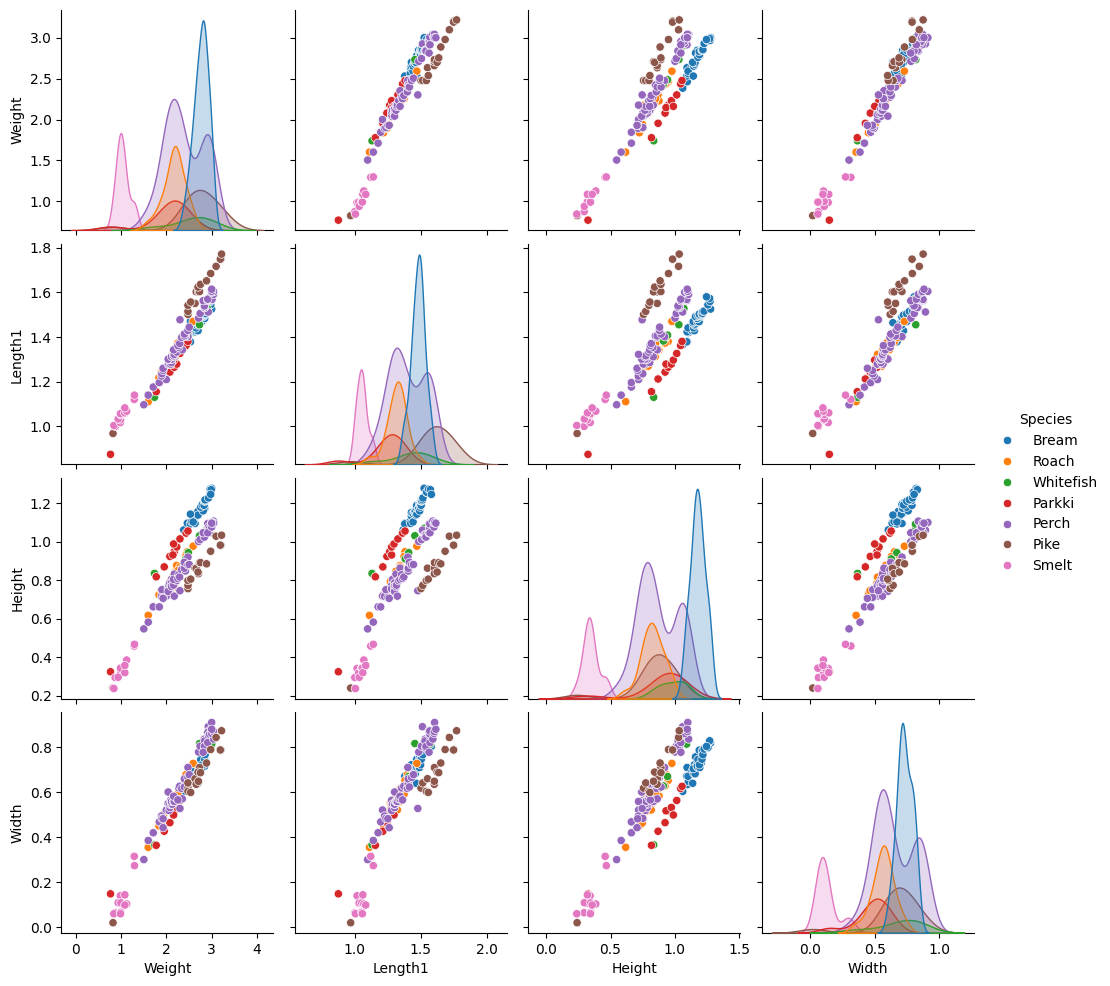

In [15]:
sns.pairplot(transformed_data, hue="Species")

Now the correlation has significantly improved, since there are straight linear correlations. Nonetheless, more than one model is going to be needed, but let's see how good a linear regressor fits into this data:

In [16]:
def get_errors(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"R^2: {r_squared:.2f}")
    print(f"MAPE: {mape:.2f}%")

The provided function will be called in order to calculate

MAE: Absolute difference between true and predicted values.
MSE: Average squared difference between true and predicted values. Captures better large errors
R-squared: Indicates how much variance in the target variable is explained by the model.
MAPE: Measures the average percentage difference between true and predicted values.

## Linear Regressor

In [25]:
df.head()

,Species,Weight,Length1,Height,Width
0,Bream,242.0,23.2,11.5200,4.0200
1,Bream,290.0,24.0,12.4800,4.3056
2,Bream,340.0,23.9,12.3778,4.6961
3,Bream,363.0,26.3,12.7300,4.4555
4,Bream,430.0,26.5,12.4440,5.1340


In [47]:
X = df.drop(columns=['Weight'])
y= df['Weight']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3)
                                                    # stratify=X['Species'])

y_train = log_transform(y_train)

ct = ColumnTransformer([
    ("numericals", FunctionTransformer(log_transform), X_train.select_dtypes(include=['float64']).columns),
    ("categories", OneHotEncoder(), X_train.select_dtypes(include=['object']).columns)
])

pipeline = Pipeline(steps=[('preprocessor', ct),
                           ('regressor', LinearRegression())])

pipeline.fit(X_train, y_train)
y_pred = 10 ** pipeline.predict(X_test)

coefficients = pipeline.named_steps['regressor'].coef_
intercept = pipeline.named_steps['regressor'].intercept_

print(f"Coefficients (weights) of the regression model: {coefficients} \n and the intercept is: {intercept}")


Coefficients (weights) of the regression model: [ 1.66274674  0.67326167  0.63234142 -0.01092323  0.01014451  0.02346599
 -0.01678444  0.01011533 -0.0760702   0.06005204] 
 and the intercept is: -0.9430702781313345


This implementation fits a linear regressin model. The pipeline consists in two steps, first, data is prerpocessed, the numerical values are logarithmic transformed while the categories one-hot encoded. After that, the model is fit and parameters calculated.

In [48]:
get_errors(y_test, y_pred)

MAE: 28.54
MSE: 3421.33
R^2: 0.97
MAPE: 5.84%


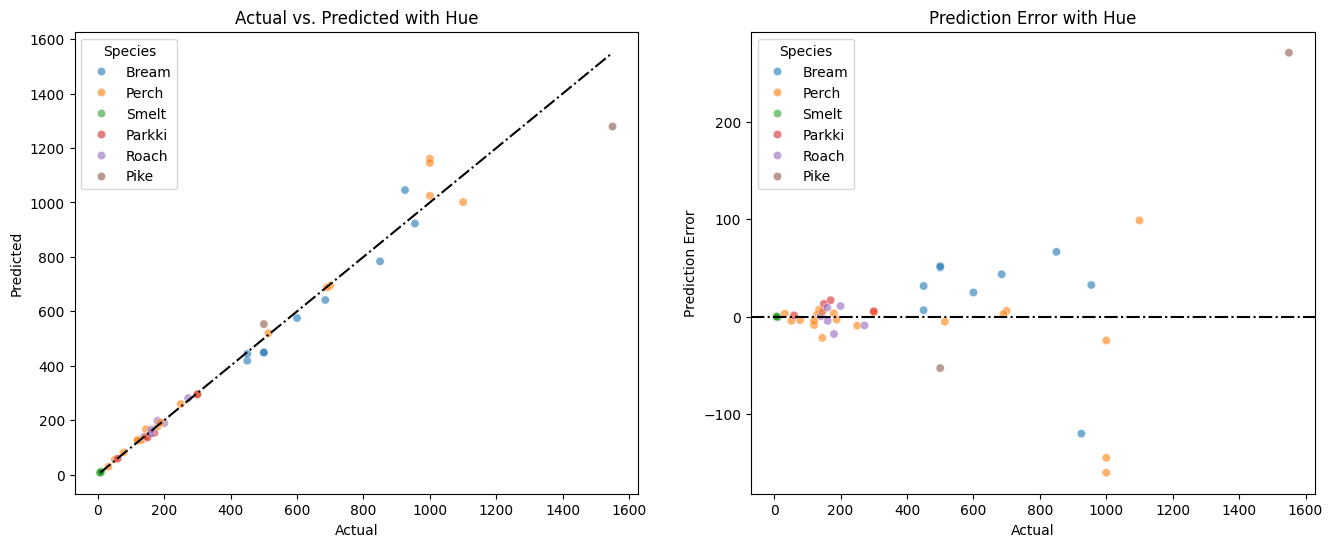

In [56]:
results = pd.DataFrame({'y_test': y_test,
                       'y_pred': y_pred})

results = results.merge(df['Species'], 
                        how='left', 
                        left_index=True, 
                        right_index=True)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(
    x=results['y_test'],
    y=results['y_pred'],
    hue=results['Species'],
    ax=ax1,
    alpha=0.6
)
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.set_title('Actual vs. Predicted with Hue')

sns.scatterplot(
    x=results['y_test'],
    y=results['y_test'] - results['y_pred'],  
    hue=results['Species'],
    ax=ax2,
    alpha=0.6
)

ax1.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='-.', color='black')
ax2.axhline(0, ls='-.', color="black")
ax2.set_xlabel('Actual')
ax2.set_ylabel('Prediction Error')
ax2.set_title('Prediction Error with Hue')

plt.show()

## Multiple Linear Regressor

As it is seen in the plots, the model performs good enough for low weights (the part when the lines are closer) but struggles in larger values. To make it simple, we are goping to implement one model for each class. Nonetheless, it is worth mentioning that there are very little datasets. Thus, more data should be added to increase accuracy.

In [53]:
df.head()

,Species,Weight,Length1,Height,Width
0,Bream,242.0,23.2,11.5200,4.0200
1,Bream,290.0,24.0,12.4800,4.3056
2,Bream,340.0,23.9,12.3778,4.6961
3,Bream,363.0,26.3,12.7300,4.4555
4,Bream,430.0,26.5,12.4440,5.1340


In [54]:
def multiple_regressor(df):
    category = df.Species.unique()
    
    X = df.drop(columns=['Weight', 'Species'])
    y= df['Weight']

    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y,
                                                        test_size=0.3,
                                                        # random_state=42
                                                        )
    
    y_train = log_transform(y_train)

    ct = ColumnTransformer([
        ("numericals", FunctionTransformer(log_transform), X_train.select_dtypes(include=['float64']).columns),
        # ("categories", OneHotEncoder(), X_train.select_dtypes(include=['object']).columns)
    ])

    pipeline = Pipeline(steps=[('preprocessor', ct),
                            ('regressor', LinearRegression())])

    pipeline.fit(X_train, y_train)
    y_pred = 10 ** pipeline.predict(X_test)

    coefficients = pipeline.named_steps['regressor'].coef_
    intercept = pipeline.named_steps['regressor'].intercept_
    get_errors(y_test, y_pred)

    print(f"category: {category}. Coefficients (weights) of the regression model: {coefficients} \n and the intercept is: {intercept}")
    

In [55]:
for i in df.Species.unique():
    multiple_regressor(df[df['Species']== i])

MAE: 49.42
MSE: 4980.57
R^2: 0.83
MAPE: 10.60%
category: ['Bream']. Coefficients (weights) of the regression model: [1.20427425 1.0871238  0.44568346] 
 and the intercept is: -0.6165200338527668
MAE: 6.10
MSE: 55.36
R^2: 0.95
MAPE: 6.20%
category: ['Roach']. Coefficients (weights) of the regression model: [0.93507494 0.50803863 1.33240942] 
 and the intercept is: -0.22862890977932615
MAE: 14.95
MSE: 360.52
R^2: 0.99
MAPE: 4.56%
category: ['Whitefish']. Coefficients (weights) of the regression model: [1.65852561 1.22382235 0.17518044] 
 and the intercept is: -1.0855964622577896
MAE: 7.01
MSE: 85.58
R^2: 0.99
MAPE: 4.67%
category: ['Parkki']. Coefficients (weights) of the regression model: [1.40697626 0.57747735 0.9396268 ] 
 and the intercept is: -0.6627127585555015
MAE: 34.25
MSE: 4310.26
R^2: 0.97
MAPE: 8.76%
category: ['Perch']. Coefficients (weights) of the regression model: [1.71062971 0.39714778 0.87995005] 
 and the intercept is: -0.9044992712450037
MAE: 65.59
MSE: 11078.37
R^2: 

*Conclusion*

The fisherman now has an easier job which sonsits in filling three values in the tk inter app.

This has been a clear scenario where data transformation fits better than other approaches such as Polynomial degrees ingested on linear regressors.

More data should be considered in order to increase model's performance.

# Old

To get started, as has been observed, the spices play a crucial role because they are grouped into clusters. Therefore, to begin, a single spice has been selected to implement a simple linear regression

In [63]:
perch_df = df[df['Species'] == 'Perch'].drop(columns=['Species']).reset_index().drop(columns=['index'])
perch_df.head()

,Weight,Length1,Height,Width
0,5.9,7.5,2.1120,1.4080
1,32.0,12.5,3.5280,1.9992
2,40.0,13.8,3.8240,2.4320
3,51.5,15.0,4.5924,2.6316
4,70.0,15.7,4.5880,2.9415


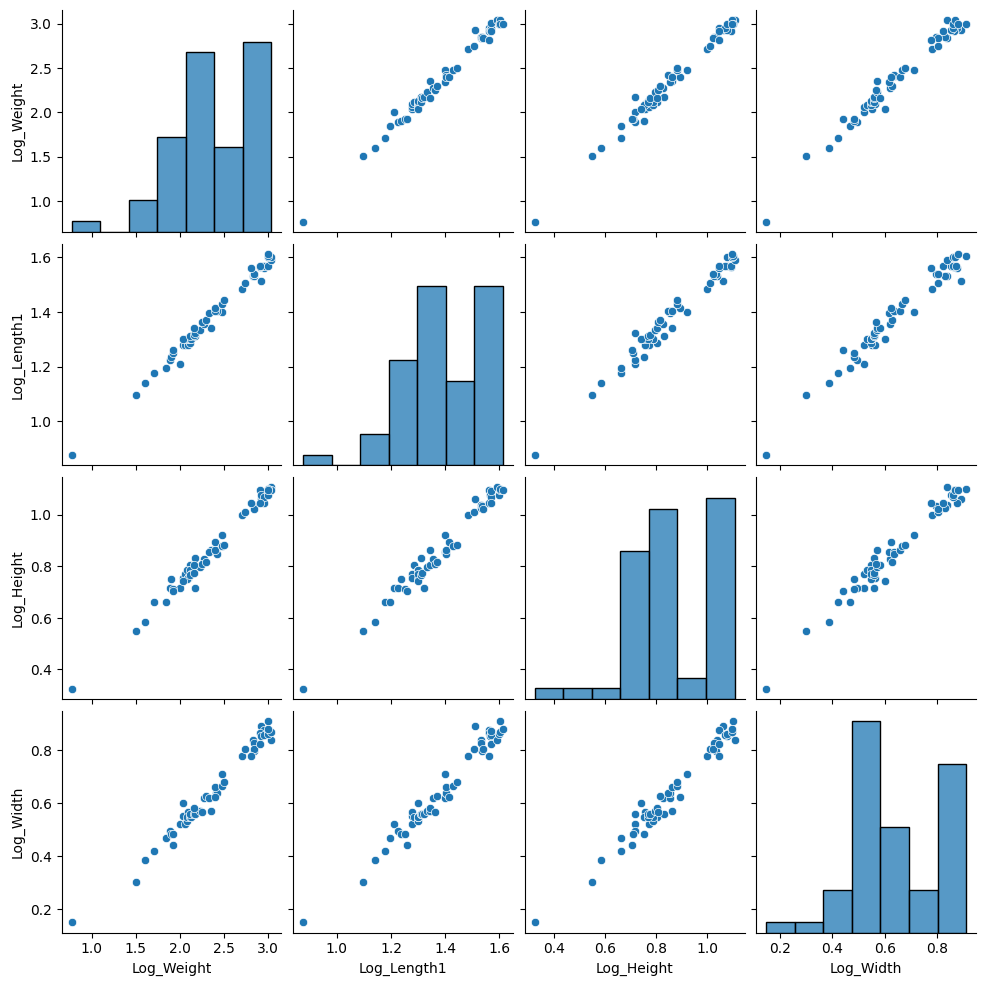

In [51]:
sns.pairplot(perch_df)

In the pairplot, quadratic and linear regression are observed. Let's start by fitting a linear regression. Rightafter, polynominalfeatures will add more degrees to the model, and the results are going to be compared.

In [66]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LinearRegression())])


X = perch_df.drop(columns=['Weight'])
y=perch_df['Weight']

kf = KFold(n_splits=3, shuffle=True)

r2_training = []
rmse_training = []
r2_test = []
rmse_test = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipe.fit(X_train, y_train)
    y_pred_train = pipe.predict(X_train)
    y_pred_test = pipe.predict(X_test)

    rmse_training.append(mean_absolute_error(y_train, y_pred_train))
    r2_training.append(r2_score(y_train, y_pred_train))
    rmse_test.append(mean_absolute_error(y_test, y_pred_test))
    r2_test.append(r2_score(y_test, y_pred_test))

print(f'MAE training: {rmse_training}, in test: {rmse_test}')
print(f'R2 training: {r2_training}, in test: {r2_test}')

MAE training: [57.444302591594905, 56.451868521875184, 62.708144961014284], in test: [83.00548652406327, 86.74515864471914, 62.724598841338235]
R2 training: [0.9604305145171971, 0.9428989979529494, 0.9344444327692077], in test: [0.8057142541146405, 0.9096715795133138, 0.953595388171186]


this first model is built using a pipeline that first standardizes the values and then fits the linear regression to estimate the parameters. Additionally, k-fold cross-validation with three splits is implemented to avoid overfitting. The error metrics selected for this case are MAE and R^2. Since this fish class has the most variance, as seen in the boxplot in the previous section, the expected results may be less accurate than for other species. However, adding more data will improve the model's performance. The training error and the test error present similar results, so there is no overfitting. Finally, the R^2 close to 1 indicates that a significant portion of the variance is explained by the model.

In [22]:
X = perch_df.drop(columns=['Weight'])
y=perch_df['Weight']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

mae: 68.10338812833567 and r2 : 0.9161045975024179
Coefficients (weights) of the polynomial regression model:
[ 71.20734855 179.704176    75.12304957]

Intercept of the polynomial regression model:
393.84615384615387


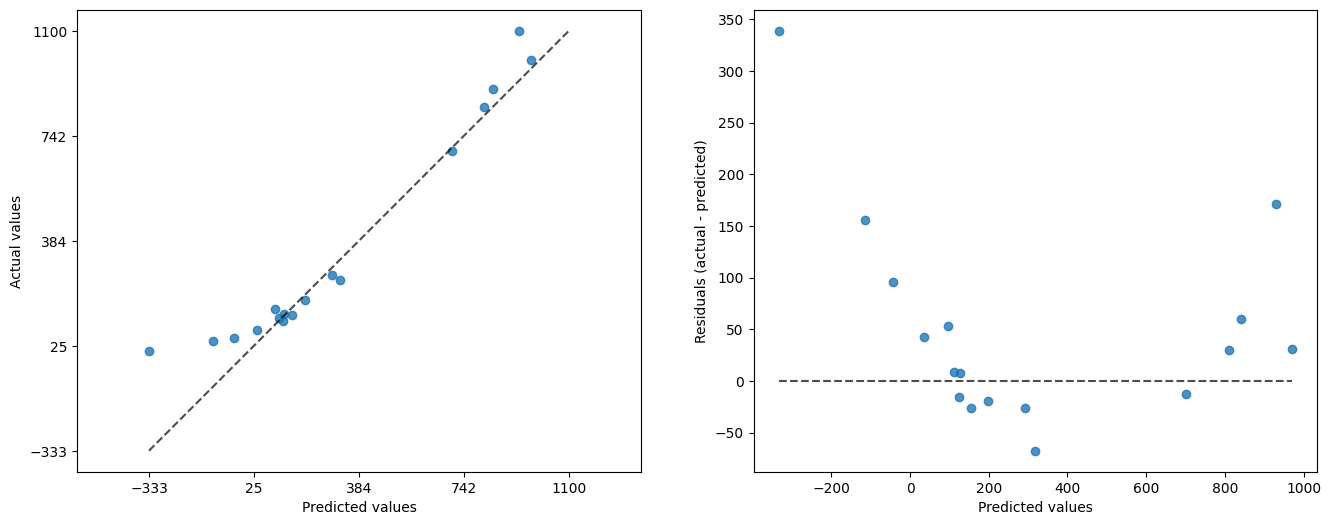

In [23]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LinearRegression())])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'mae: {mae} and r2 : {r2}')

coefficients = pipe.named_steps['lr'].coef_
intercept = pipe.named_steps['lr'].intercept_

print("Coefficients (weights) of the polynomial regression model:")
print(coefficients)
print("\nIntercept of the polynomial regression model:")
print(intercept)


f, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
PredictionErrorDisplay.from_predictions(y_true=y_test, y_pred=y_pred, kind= "actual_vs_predicted", ax=ax1)
PredictionErrorDisplay.from_predictions(y_true=y_test, y_pred=y_pred, ax=ax2)

The first linear regression performs correctly, given the short dataset presented, as well as the high variance for this species. The residuals show how much the predicted values differ from the real ones. The actual-vs-predicted plot gives an overall idea of the scale of the errors. The MAE is 60, and the coefficients represent the slopes of the features; the greater the coefficient, the more important the feature is. Actually, it is observed that there is a feature that outperforms the others, which is the Height

mae: 31.997210921403777 and r2 : 0.9833551490161458
Coefficients (weights) of the polynomial regression model:
[ 119.3826493    83.04881757  104.69496768  117.22291375 -241.12751353
   82.89002144  504.0440367  -660.69589047  277.15500844]

Intercept of the polynomial regression model:
295.7595853671835


<Figure size 1600x600 with 0 Axes>

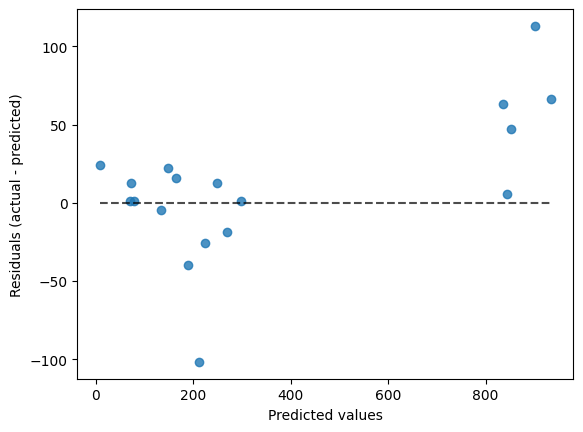

In [67]:
pipe = Pipeline([("ss", StandardScaler()),
                 ("poly", PolynomialFeatures(include_bias=False, degree=2)),
                 ("lr", LinearRegression())])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'mae: {mae} and r2 : {r2}')

coefficients = pipe.named_steps['lr'].coef_
intercept = pipe.named_steps['lr'].intercept_

print("Coefficients (weights) of the polynomial regression model:")
print(coefficients)
print("\nIntercept of the polynomial regression model:")
print(intercept)

plt.figure(figsize=(16,6))
PredictionErrorDisplay.from_predictions(y_true=y_test, y_pred=y_pred)

In this other model, the performance is much more accurate, with a MAE equal to 17. It is observed that more coefficients have been added due to the implementation of a second-degree model. Therefore, it can be concluded that polynomial features increase performance. The results with a degree equal to 3 were less accurate.

## Standard model

In [68]:
df.head(6)

,Species,Weight,Length1,Height,Width
0,Bream,242.0,23.2,11.5200,4.0200
1,Bream,290.0,24.0,12.4800,4.3056
2,Bream,340.0,23.9,12.3778,4.6961
3,Bream,363.0,26.3,12.7300,4.4555
4,Bream,430.0,26.5,12.4440,5.1340
5,Bream,450.0,26.8,13.6024,4.9274


In [69]:
# ELogarithmic transformation
df['Log_Weight'] = np.log10(df['Weight'])
df['Log_Length1'] = np.log10(df['Length1'])
df['Log_Height'] = np.log10(df['Height'])
df['Log_Width'] = np.log10(df['Width'])
df_bck = df.copy()
df.drop(columns=['Weight', 'Length1', 'Height', 'Width'], inplace=True)

In [70]:
df

,Species,Log_Weight,Log_Length1,Log_Height,Log_Width
0,Bream,2.383815,1.365488,1.061452,0.604226
1,Bream,2.462398,1.380211,1.096215,0.634034
2,Bream,2.531479,1.378398,1.092643,0.671737
3,Bream,2.559907,1.419956,1.104828,0.648896
4,Bream,2.633468,1.423246,1.094960,0.710456
...,...,...,...,...,...
154,Smelt,1.086360,1.060698,0.320229,0.144138
155,Smelt,1.127105,1.068186,0.385606,0.103462
156,Smelt,1.086360,1.082785,0.357363,0.098920
157,Smelt,1.294466,1.120574,0.458305,0.315382


mae: 28.757606611087066 and r2 : 0.9962969049218038


<Figure size 1600x600 with 0 Axes>

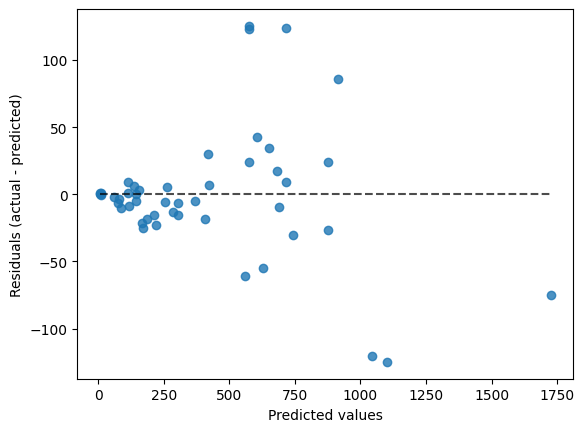

In [87]:
X = df.drop(columns=['Log_Weight'])
y= df['Log_Weight']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

ct = ColumnTransformer([
    ("numericals", StandardScaler(), X_train.select_dtypes(include=['float64']).columns),
    ("categories", OneHotEncoder(), X_train.select_dtypes(include=['object']).columns)
])

pipeline = Pipeline(steps=[('preprocessor', ct),
                           ('regressor', LinearRegression())])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

inverse_y_pred = [10**x for x in y_pred]
inverse_y_test = [10**x for x in y_test]

mae = mean_absolute_error(inverse_y_test, inverse_y_pred)
r2 = r2_score(y_test, y_pred)
print(f'mae: {mae} and r2 : {r2}')

plt.figure(figsize=(16,6))
PredictionErrorDisplay.from_predictions(y_true= np.array(inverse_y_test), y_pred=np.array(inverse_y_pred))

Low error when we have more information. This model captures better lower errors than large ones. If the species form clusters, it will suggest that a model is needed for each species.

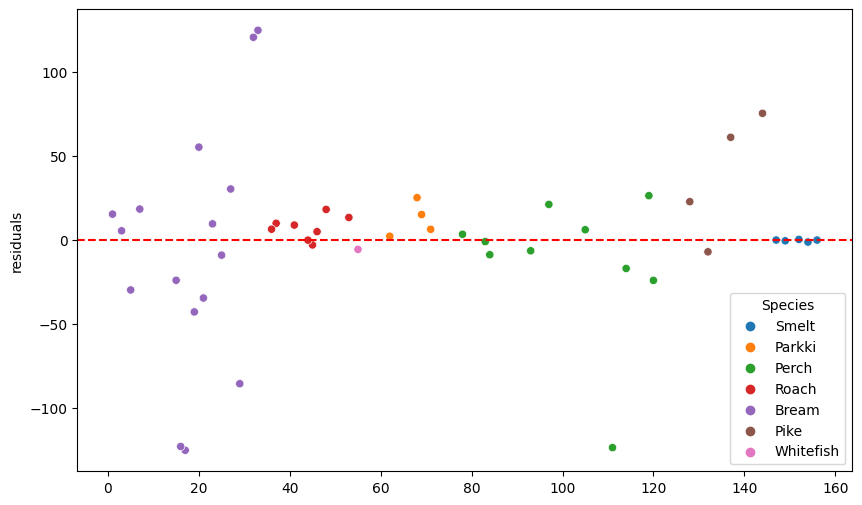

In [109]:
data_dic = {
    'ypred' : inverse_y_pred,
    'ytest' : inverse_y_test,
    'Species' : X_test['Species'] 
}
predictions = pd.DataFrame(data_dic)

# predictions = pd.DataFrame(data_dic).reset_index().drop(columns=["index"])
predictions['residuals'] = predictions['ypred']-predictions["ytest"]
plt.figure(figsize=(10,6))

sns.scatterplot(data=predictions, x=predictions.index, y="residuals", hue= "Species")
plt.axhline(y=0, color='red', linestyle='--', label='Zero Residuals Line')

This results clustered show that a single model for each species is required